# Neural Style Transfer

Neural style transfer consist of applying the style of a reference image to a targe image while conserving the conent of the target.

![](neural-style-transfer.jpeg)

In this context, *style* means texture, colors, and visual patterns in the image, at caripus spatial scales; and the *content* is the higher-level macrostructure of the image.

The key notion behind implementing style transfer is the sam idea that's central to all deep learning algorithms: you define a loss function to specify what you want to achieve, in this case *applying the style of a reference image to a targe image while conserving the conent of the target*. Then an appropiate loss function to minimize would be the following:

```
loss = distance(style(reference_image) - style(generated_image)) + 
        distance(content(original_image) - content(generated_image))
```

- `distance`: L2 norm
- `content`: function that takes an image and computes a representation of its content (CNNs can encode content) 
- `style`: function that takes an image and computes a representations of its style (CNNs can encode style)

So ->

- Preserve content by maintaining similar high-level layer activations between the target content and the generated one.
- Preserve style by maintaining similar *correlations* within activation for both lower-level layers and high-level-layers. Feature correlations capture *textures*. 

## A Neural Algorithm of Artistic Style (2015) implementation

1. Set up anetwork that computes VGG19 layers activations for style reference image, target image and generated image
2. Use the layers activations computed over this three images to define the loss function
3. Set up a gradient-descent process to minimize the loss

In [1]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.applications import vgg19

Using TensorFlow backend.


In [2]:
!ls

 dd.jpg				 'Neural Style Transfer.ipynb'
 DeepDream.ipynb		  neural-style-transfer.jpeg
'dream_at_scale_(169, 255).png'   original_dd.jpeg
'dream_at_scale_(237, 357).png'   original-st.jpg
'dream_at_scale_(332, 500).png'   style.jpg
 final_dream.png		 'Text generation with LSTM.ipynb'


In [3]:
target_image_path = 'original-st.jpg'
style_reference_image_path = 'style.jpg'

width, height = load_img(target_image_path).size

# Calculate dimentions of the generated image
# All images shares 400px of height
img_height = 400
img_width = int(width * img_height / height) # keep proportion

In [4]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939 # Reverse transformation of data standarization
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # Convert image from BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
import keras.backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([
    target_image,
    style_reference_image,
    combination_image
], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


Define the losses

In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    # Inner product of the feature maps of given layer
    # Inner product can be understood as representing a map of the correlation between the layer's features
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Regularization loss
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, 1:, :img_width - 1, :]
    )
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, :img_height -1, 1:, :]
    )
    return K.sum(K.pow(a + b, 1.25))

In [7]:
output_dict = {layer.name: layer.output for layer in model.layers}
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1
content_weight = .025

In [8]:
loss = K.variable(0.)
layer_features = output_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight* content_loss(target_image_features, combination_features)

for l in style_layers:
    layer_features = output_dict[l]
    combination_image_features = layer_features[2, :, :, :]
    style_features = layer_features[1, :, :, :]
    loss += (style_weight / len(style_layers)) * style_loss(style_features, combination_image_features)
    
loss += total_variation_weight * total_variation_loss(combination_image)

Finally, we'll set up the gradient descent process. In the original paper, optimization is performed using the L-BFGS algorithm, so that's what we'll be using.

In [9]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [10]:
# Adapter for using L-BFGS algorithm in scipy
class Evaluator(object):
    # This class allows fetching loss and gradients separately
    def __init__(self):
        self.loss_val = None
        self.grads_val = None
        
    def loss(self, x):
        assert self.loss_val is None
        x = x.reshape((1, img_height, img_width, 3))
        self.loss_val, self.grads_val = fetch_loss_and_grads([x])
        self.grads_val = self.grads_val.flatten().astype('float64')
        return self.loss_val
    
    def grads(self, x):
        assert self.loss_val is not None
        grads_val = np.copy(self.grads_val)
        self.loss_val = None
        self.grads_val = None
        return grads_val
    
evaluator = Evaluator()

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('current_loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + 'at_iteration_{}.png'.format(i)
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration {} completed in {}s'.format(i, end_time - start_time))

Start of iteration 0
current_loss value: 1181714800.0
Image saved as my_resultat_iteration_0.png
Iteration 0 completed in 329.6966235637665s
Start of iteration 1


/home/guillem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


current_loss value: 529797380.0
Image saved as my_resultat_iteration_1.png
Iteration 1 completed in 327.6149859428406s
Start of iteration 2
current_loss value: 357429540.0
Image saved as my_resultat_iteration_2.png
Iteration 2 completed in 330.16375613212585s
Start of iteration 3
current_loss value: 277164800.0
Image saved as my_resultat_iteration_3.png
Iteration 3 completed in 327.363648891449s
Start of iteration 4
current_loss value: 223323120.0
Image saved as my_resultat_iteration_4.png
Iteration 4 completed in 383.9391314983368s
Start of iteration 5
current_loss value: 188914560.0
Image saved as my_resultat_iteration_5.png
Iteration 5 completed in 357.06610441207886s
Start of iteration 6
current_loss value: 165149380.0
Image saved as my_resultat_iteration_6.png
Iteration 6 completed in 338.1760964393616s
Start of iteration 7
current_loss value: 146630600.0
Image saved as my_resultat_iteration_7.png
Iteration 7 completed in 335.29460430145264s
Start of iteration 8
current_loss value

In [15]:
style_img = load_img(style_reference_image_path, target_size=(img_height, img_width))
original_img = load_img(target_image_path, target_size=(img_height, img_width))
combined_image = load_img('my_resultat_iteration_19.png', target_size=(img_height, img_width))

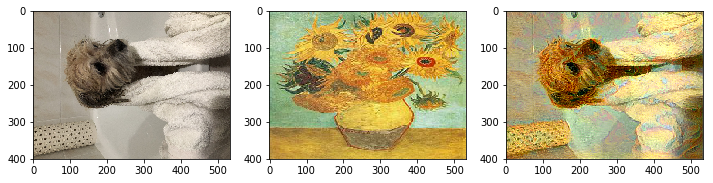

In [26]:
import matplotlib.pyplot as plt


f, axarr = plt.subplots(1, 3, figsize=(12, 12))
axarr[0].imshow(original_img)
axarr[1].imshow(style_img)
axarr[2].imshow(combined_image)